In [215]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from functools import partial
import scipy as sp
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report

In [2]:
# Verification: read the files into dataframes
files = ["../Data/model_data/model-encoded-data-0.csv", 
         "../Data/model_data/model-encoded-data-1.csv", 
         "../Data/model_data/model-encoded-data-2.csv"]
model_dfs = [pd.read_csv(f, sep=",", 
                          encoding='Latin-1', 
                          low_memory=False ) for f in files]

# combine the list of dataframes
df = pd.concat(model_dfs, ignore_index=True)

In [3]:
df.head()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_occupation_web_developer,is_IT_expr_2_to_5,is_IT_expr_6_to_10,is_IT_expr_above_11,is_IT_expr_below_2,compensation,year,country,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,above-160000,2019,United States,8,65094.79943
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,above-160000,2019,United States,8,65094.79943
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,above-160000,2019,United States,8,65094.79943
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,above-160000,2019,United States,8,65094.79943
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,above-160000,2019,United States,8,65094.79943


In [4]:
df.columns

Index(['is_female', 'is_male', 'is_gender_non_confirming', 'is_transgender',
       'is_gender_unknown', 'is_age_18_to_24', 'is_age_25_to34',
       'is_age_35_44', 'is_age_45_54', 'is_age_55_to_64', 'is_age_above_65',
       'is_age_below_18', 'is_company_size_1000_to_4999',
       'is_company_size_100_to_499', 'is_company_size_5000_to_9999',
       'is_company_size_500_to_999', 'is_company_size_unknown',
       'is_company_size_above_10000', 'is_company_size_below_100',
       'is_desktop_os_linux', 'is_desktop_os_mac', 'is_desktop_os_unix',
       'is_desktop_os_windows', 'is_lang_c#', 'is_lang_c_c++',
       'is_lang_hadoop', 'is_lang_html_css', 'is_lang_java',
       'is_lang_javascript_nodejs', 'is_lang_lua', 'is_lang_objective_C',
       'is_lang_other', 'is_lang_perl', 'is_lang_php', 'is_lang_powershell',
       'is_lang_python', 'is_lang_r', 'is_lang_ruby', 'is_lang_scala',
       'is_lang_sql', 'is_lang_swift', 'is_lang_visual_basic',
       'is_occupation_c_suite', 'is_occup

In [5]:
#Don't use these columns
cols_excl = ['country', 'year']
df = df.drop(cols_excl, axis=1)

In [6]:
#df_salary is a dataframe after dropping data points with NaN in 'compensation'
df_salary = df.dropna(subset=['compensation'])[df.dropna(subset=['compensation'])['compensation']!=0]
print('Dataframe without NaN and 0 in compensation is {}%'.format(round(len(df_salary)/len(df)*100, 2)), 'of the original dataframe.')
print('There are {}'.format(len(df_salary)), 'data points in it compared to {}'.format(len(df)), 'entries in the original dataframe.\n')
print('Information on missing values in the dataframe df_salary:')
df_salary.isna().sum()/len(df_salary)*100

Dataframe without NaN and 0 in compensation is 100.0% of the original dataframe.
There are 252740 data points in it compared to 252740 entries in the original dataframe.

Information on missing values in the dataframe df_salary:


is_female                   0.0
is_male                     0.0
is_gender_non_confirming    0.0
is_transgender              0.0
is_gender_unknown           0.0
                           ... 
is_IT_expr_above_11         0.0
is_IT_expr_below_2          0.0
compensation                0.0
job_satisfaction            0.0
GDP                         0.0
Length: 61, dtype: float64

In [7]:
df_salary['compensation'].unique()

array(['above-160000', '80000-100000', '100000-120000', '60000-to-80000',
       '120000-140000', '140000-160000', '40000-60000', '20000-40000',
       'below-20000', '60000-80000'], dtype=object)

In [8]:
comp_int_dict = {'below-20000': 1, '20000-40000': 2, '40000-60000': 3, '60000-to-80000': 4, "60000-80000": 4, 
                 '80000-100000': 5,'100000-120000': 6, '12000-140000': 7, '120000-140000':7,
                 '140000-160000': 8, 'above-160000': 9}

In [9]:
df_salary.replace({'compensation':comp_int_dict}, inplace=True)

In [10]:
df_salary['compensation'].unique()

array([9, 5, 6, 4, 7, 8, 3, 2, 1], dtype=int64)

In [11]:
df_salary.head()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_occupation_other,is_occupation_system_admin,is_occupation_web_developer,is_IT_expr_2_to_5,is_IT_expr_6_to_10,is_IT_expr_above_11,is_IT_expr_below_2,compensation,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,8,65094.79943
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9,8,65094.79943
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,8,65094.79943
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,8,65094.79943
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9,8,65094.79943


In [12]:
#Define data (predictors) and response
data_df = df_salary.drop('compensation', axis=1)

# Some code to scale numerical data
cols_to_scale = ['job_satisfaction', 'GDP']
train_numerical = data_df[cols_to_scale].copy()
sc = StandardScaler()
sc.fit(train_numerical)
train_scaled = sc.transform(train_numerical)
train_scaled = pd.DataFrame(train_scaled, columns = train_numerical.columns)
data_df_scaled = pd.concat([data_df.drop(cols_to_scale, axis=1), train_scaled], axis=1)
display(data_df_scaled.head()) #scaled job satisfaction and GDP data
 
print(data_df_scaled.columns) #checking that 'compensation' is not there
data = data_df_scaled.to_numpy()
#Temporarily drop GDP
# data = data_df_scaled.drop('GDP', axis=1).to_numpy()
salary = df_salary['compensation'].to_numpy()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_occupation_not_in_tech,is_occupation_other,is_occupation_system_admin,is_occupation_web_developer,is_IT_expr_2_to_5,is_IT_expr_6_to_10,is_IT_expr_above_11,is_IT_expr_below_2,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.33255,1.119652
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.33255,1.119652
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.33255,1.119652
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.33255,1.119652
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.33255,1.119652


Index(['is_female', 'is_male', 'is_gender_non_confirming', 'is_transgender',
       'is_gender_unknown', 'is_age_18_to_24', 'is_age_25_to34',
       'is_age_35_44', 'is_age_45_54', 'is_age_55_to_64', 'is_age_above_65',
       'is_age_below_18', 'is_company_size_1000_to_4999',
       'is_company_size_100_to_499', 'is_company_size_5000_to_9999',
       'is_company_size_500_to_999', 'is_company_size_unknown',
       'is_company_size_above_10000', 'is_company_size_below_100',
       'is_desktop_os_linux', 'is_desktop_os_mac', 'is_desktop_os_unix',
       'is_desktop_os_windows', 'is_lang_c#', 'is_lang_c_c++',
       'is_lang_hadoop', 'is_lang_html_css', 'is_lang_java',
       'is_lang_javascript_nodejs', 'is_lang_lua', 'is_lang_objective_C',
       'is_lang_other', 'is_lang_perl', 'is_lang_php', 'is_lang_powershell',
       'is_lang_python', 'is_lang_r', 'is_lang_ruby', 'is_lang_scala',
       'is_lang_sql', 'is_lang_swift', 'is_lang_visual_basic',
       'is_occupation_c_suite', 'is_occup

In [13]:
np.unique(salary)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [14]:
data.shape

(252740, 60)

In [15]:
salary.shape

(252740,)

In [16]:
#Could be nice for visualization for model report, compare with real values
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


#Could be used to include in a model report, compare with real values
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

#Define evaluation metric
def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating = None
    max_rating = None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

## Light Gradient Boosting Machine regressor ##

**Rounding to nearest integer**

5-fold CV

In [29]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
    model = lgb.LGBMRegressor()
    pred = model.fit(X_train, y_train).predict(X_test).astype(np.int32) #rounding to nearest integer
    qwk = quadratic_weighted_kappa(pred,y_test)
    cv_scores[idx] = qwk

In [25]:
print('For LGBM rounding to the nearest integer the mean quadratic weighted kappa score in stratified 5-fold CV is {}.'.format(np.mean(cv_scores)))

For LGBM rounding to the nearest integer the mean quadratic weighted kappa score in stratified 5-fold CV is 0.6225676657816221.


Score for test set

In [30]:
#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

test_y = y_test
gbm_reg = lgb.LGBMRegressor()
gbm_reg.fit(X=x_train, y=y_train)
pred_test_y_k = gbm_reg.predict(x_test).astype(np.int32) #rounding to nearest integer
qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
print("Test set QWK for LGBM regressor with rounding of salary categories to nearest integer is", qwk)

Test set QWK for LGBM regressor with rounding of salary categories to nearest integer is 0.6216168228947487


**Optimized rounding**

In [162]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            elif pred >= coef[4] and pred < coef[5]:
                X_p[i] = 5
            elif pred >= coef[5] and pred < coef[6]:
                X_p[i] = 6
            elif pred >= coef[6] and pred < coef[7]:
                X_p[i] = 7
            elif pred >= coef[7] and pred < coef[8]:
                X_p[i] = 8
            else:
                X_p[i] = 9

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            elif pred >= coef[4] and pred < coef[5]:
                X_p[i] = 5
            elif pred >= coef[5] and pred < coef[6]:
                X_p[i] = 6
            elif pred >= coef[6] and pred < coef[7]:
                X_p[i] = 7
            elif pred >= coef[7] and pred < coef[8]:
                X_p[i] = 8
            else:
                X_p[i] = 9
        return X_p

    def coefficients(self):
        return self.coef_['x']

#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

cv_scores_opt = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#Optimal parameters from optuna study - see below for code
opt_params = {'learning_rate': 0.12752857768803944, 'max_depth': 9, 'lambda_l1': 15, 'lambda_l2': 100}


##################################################################################################################
#Code to run hyperparameter tuning - this was run on a server

# def objective(trial):
#     param_grid = {
# #                 "device_type": trial.suggest_categorical("device_type", ['gpu']),
# #         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
# #         "num_leaves": trial.suggest_int("num_leaves", 10, 200, step=5),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
# #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
# #         "max_bin": trial.suggest_int("max_bin", 200, 300),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#     }
#     cv_scores_opt = np.empty(5)
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

#     #For train set, make further splits for CV
#     for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
#         X_train, X_test = data_train[train_idx], data_train[test_idx]
#         y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
#         model = lgb.LGBMRegressor(**param_grid)
#         pred = model.fit(X_train, y_train).predict(X_test)
#         optR = OptimizedRounder()
#         optR.fit(pred, y_test)
#         coefficients = optR.coefficients()
#         pred_test_y_k = optR.predict(pred, coefficients)
#         qwk = quadratic_weighted_kappa(pred_test_y_k,y_test)
#         cv_scores_opt[idx] = qwk
#         return np.mean(cv_scores_opt)

# study = optuna.create_study(direction='maximize', study_name='LGBM regressor')
# func = lambda trial: objective(trial)
# study.optimize(func, n_trials=2000)

##################################################################################################################

coefficients_arr = 0
#For train set, make further splits for CV
for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
    model = lgb.LGBMRegressor(**opt_params)
    pred = model.fit(X_train, y_train).predict(X_test)
    optR = OptimizedRounder()
    optR.fit(pred, y_test)
    coefficients = optR.coefficients()
    coefficients_arr+=coefficients
    pred_test_y_k = optR.predict(pred, coefficients)
    qwk = quadratic_weighted_kappa(pred_test_y_k,y_test)
    cv_scores_opt[idx] = qwk

[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Curr

In [163]:
print('Mean quadratic weighted kappa score for stratified 5-fold CV for LGBM regressor is', np.mean(cv_scores_opt))

Mean quadratic weighted kappa score for stratified 5-fold CV for LGBM regressor is 0.6898117560977386


Default model CV score: 0.6878138056466964

Fitting and evaluation of model for test set

In [164]:
#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

test_y = y_test
gbm_reg = lgb.LGBMRegressor(**opt_params)
gbm_reg.fit(X=x_train, y=y_train)
pred_test_y = gbm_reg.predict(x_test)
gbm_reg_pred = pred_test_y

coefficients_final = coefficients_arr/5 #using means of optimized coefficients from CV
print('Coefficients final are', coefficients_final)

optR = OptimizedRounder()
optR.coef_ = coefficients_final
pred_test_y_k = optR.predict(gbm_reg_pred, coefficients_final)
print('gbm_reg_pred is', gbm_reg_pred)
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients_final)
qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
print("Test set QWK for LGBM regressor with optimized rounding of salary categories is", qwk)

[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
Coefficients final are [0.4852367  2.17463985 3.06892879 3.62419226 4.18481718 4.89877681
 5.53266606 6.24091708 7.59763487]
gbm_reg_pred is [3.21947261 8.47100256 7.03548654 ... 1.83840353 1.55236391 3.48821841]
Predicted Counts =  Counter({1.0: 9509, 2.0: 9354, 3.0: 6293, 5.0: 6256, 4.0: 5511, 8.0: 4484, 6.0: 4324, 7.0: 3946, 9.0: 871})
Coefficients =  [0.4852367  2.17463985 3.06892879 3.62419226 4.18481718 4.89877681
 5.53266606 6.24091708 7.59763487]
Test set QWK for LGBM regressor with optimized rounding of salary categories is 0.6920378884892489


Default model test score: 0.6866261739407984

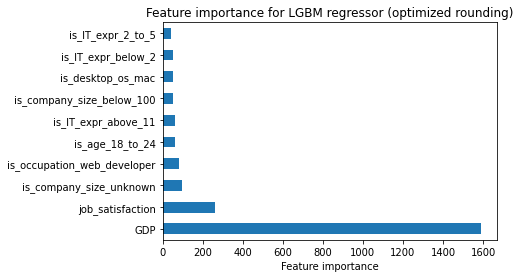

In [165]:
feature_imp = pd.DataFrame(sorted(zip(gbm_reg.feature_importances_,data_df.columns)), columns=['Value','Feature'])
feature_imp = pd.Series(gbm_reg.feature_importances_, index=data_df.columns)
feature_imp.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance')
plt.title('Feature importance for LGBM regressor (optimized rounding)')
plt.savefig('Feature importance for LGBM regressor.svg', bbox_inches='tight')

#Alternative plot
# plt.figure(figsize=(6, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:10, :])
# plt.title('LGBM regressor (optimized rounding) \n feature importance (average over folds)')
# plt.tight_layout()
# plt.savefig('LGBM regressor (optimized rounding) feature importance (average over folds).svg')
# plt.show()


## Light Gradient Boosting Machine classifier ##

In [97]:
labels = salary.astype(str)

#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

#Optimal parameters from optuna study - found that they do not improve performance over default model
opt_params = {'learning_rate': 0.16726096140196198, 'max_depth': 12, 'lambda_l1': 65, 'lambda_l2': 40}

cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
    model = lgb.LGBMClassifier(**opt_params) #treating it as a classification problem 
    pred = model.fit(X_train, y_train).predict(X_test)
    cv_scores[idx] = quadratic_weighted_kappa(pred, y_test) #but evaluation is based on integers - conversion done within function
    
print('Mean quadratic weighted kappa score for stratified 5-fold CV for optimal parameters \
        of Light GBM classifier is', np.mean(cv_scores))

#Split data into train and test datasets - do again to ensure variables are correctly assigned
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

gbm_clf = lgb.LGBMClassifier(**opt_params)
gbm_clf.fit(X=x_train, y=y_train)

gbm_clf_pred = gbm_clf.predict(x_test)
print('Mean quadratic weighted kappa score for the test split \
        of Light GBM classifier is', quadratic_weighted_kappa(gbm_clf_pred, y_test))

[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value

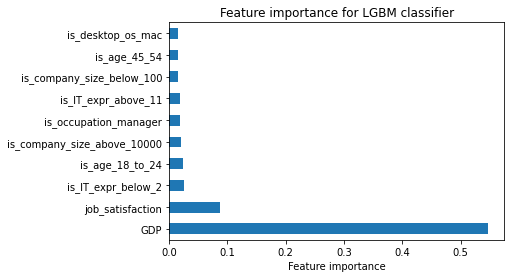

In [161]:
# feature_imp = pd.DataFrame(sorted(zip(gbm_clf.feature_importances_,data_df.columns)), columns=['Value','Feature'])
feature_imp = pd.Series(gbm_clf.feature_importances_/sum(gbm_clf.feature_importances_), index=data_df.columns)
feature_imp.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance')
plt.title('Feature importance for LGBM classifier')
plt.savefig('Feature importance for LGBM classifier.svg', bbox_inches='tight')

For the default LGBM classifier model:

Mean quadratic weighted kappa score for stratified 5-fold CV for optimal parameters         of Light GBM classifier is 0.6365364856256647
Mean quadratic weighted kappa score for the test split         of Light GBM classifier is 0.6370432511938602

In [ ]:
# feature_imp = pd.DataFrame(sorted(zip(gbm_reg.feature_importances_,data_df.columns)), columns=['Value','Feature'])
# plt.figure(figsize=(6, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LGBM classifier feature importance')
# plt.tight_layout()
# plt.savefig('LGBM classifier feature importance.svg')
# plt.show()

## Random forest regression ##

**Find optimal tree depth for sample of the data**

This done to make the search quicker.

In [60]:
labels = df_salary['compensation'].to_numpy() #continuous for regression

#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

#Randomly sample 20000 data points to work up optimal depth search
np.random.seed(0)
sample = np.random.choice(len(x_train), 20000, replace = False)
x_train = x_train[sample]
y_train = y_train[sample]

In [85]:
maxdepth_grid = list(range(1, 31))
bagging_range = np.linspace(0.001, 1, num = 25)
random_grid = {'max_depth': maxdepth_grid, 'max_samples': bagging_range, 'max_features': ['auto', 'sqrt']}
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_opt_params = rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [91]:
print('Optimal parameters for random forest regressor are', rf_opt_params)

Optimal parameters for random forest regressor are {'max_samples': 0.45887500000000003, 'max_features': 'auto', 'max_depth': 18}


**Find CV and test set scores for rounding to nearest integer for full dataset**

5-fold CV

In [109]:
cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]
#     model = RandomForestRegressor(**rf_opt_params)
    model = RandomForestRegressor(**rf_opt_params)
    pred = model.fit(X_train, y_train).predict(X_test)
    qwk = quadratic_weighted_kappa(np.rint(pred), y_test)
#         print('QWK is', qwk)
    cv_scores[idx] = qwk

In [110]:
print('Quadratic weighted Kappa for 5-fold CV for random forest regressor is', np.mean(cv_scores))

Quadratic weighted Kappa for 5-fold CV for random forest regressor is 0.6792051566803284


CV for default RF model = 0.6766893603703659

Evaluate fit to test set

In [111]:
#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)
#On test set
# model = RandomForestRegressor(max_depth = opt_depth_RFreg+1, random_state=0)
model = RandomForestRegressor(**rf_opt_params)
pred = model.fit(x_train, y_train).predict(x_test)

In [112]:
print('Quadratic weighted Kappa for the test set for random forest regressor is', quadratic_weighted_kappa(np.rint(pred), y_test))

Quadratic weighted Kappa for the test set for random forest regressor is 0.6851327088599324


Test fit for default RF = 0.6803753916858659

**Find CV and test set scores for optimized rounding**

In [166]:
cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

coefficients_arr = 0
for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]
  
    model = RandomForestRegressor(**rf_opt_params, random_state=1)
#     model = RandomForestRegressor(opt_depth_RFreg+1, random_state=0)

    pred = model.fit(X_train, y_train).predict(X_test)
    optR = OptimizedRounder()
    optR.fit(pred, y_test)
    coefficients = optR.coefficients()
    coefficients_arr+=coefficients
    pred_test_y_k = optR.predict(pred, coefficients)
    qwk = quadratic_weighted_kappa(pred_test_y_k,y_test)
    cv_scores[idx] = qwk
    
print('Quadratic weighted Kappa for 5-fold CV for random forest regressor with optimized rounding and optimal parameters is', np.mean(cv_scores))

Quadratic weighted Kappa for 5-fold CV for random forest regressor with optimized rounding and optimal parameters is 0.7132940533374058


Default random forest regressor (optimized rounding) CV score = 0.6761731656750796

In [170]:
coefficients_final = coefficients_arr/5
print('Coefficients final are', coefficients_final)


#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

test_y = y_test
# gbm_reg = RandomForestRegressor(opt_depth_RFreg+1, random_state=0)
gbm_reg = RandomForestRegressor(**rf_opt_params, random_state=1)
gbm_reg.fit(X=x_train, y=y_train)

pred_test_y = gbm_reg.predict(x_test)
gbm_reg_pred = pred_test_y

optR = OptimizedRounder()
optR.coef_ = coefficients_final
# pred_test_y_k = optR.predict(gbm_reg_pred.flatten()).astype(np.int32)
pred_test_y_k = optR.predict(gbm_reg_pred, coefficients_final)
print('gbm_reg_pred is', gbm_reg_pred)
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients_final)
qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
print("Test set QWK for random forest regressor with optimized rounding of salary categories and optimal parameters is", qwk)

Coefficients final are [0.525116   2.08460628 2.96706866 3.6477693  4.2100522  4.97003773
 5.64391857 6.47375473 7.3975181 ]
gbm_reg_pred is [3.12452335 8.15996244 7.33682493 ... 2.05208657 2.16972447 3.27523295]
Predicted Counts =  Counter({1.0: 10313, 2.0: 8901, 3.0: 6593, 5.0: 5995, 4.0: 4757, 7.0: 4422, 6.0: 4202, 8.0: 3384, 9.0: 1981})
Coefficients =  [0.525116   2.08460628 2.96706866 3.6477693  4.2100522  4.97003773
 5.64391857 6.47375473 7.3975181 ]
Test set QWK for random forest regressor with optimized rounding of salary categories and optimal parameters is 0.7169548034474826


Test set score for optimized rounding for default random forest model: 0.6863787133056631

**As LGBM regressor with optimized rounding is the best model, find accuracy, confusion matrix and ROC for it**

In [205]:
pred_test_y_k = np.array([int(x) for x in pred_test_y_k])
test_y = np.array([int(x) for x in test_y])

In [221]:
from sklearn import metrics
#Accuracy (model fit on train set, prediction for test set)
metrics.accuracy_score(test_y, pred_test_y_k)

0.3491137136978713

In [223]:
#Further metrics
print(classification_report(test_y,pred_test_y_k))

              precision    recall  f1-score   support

           1       0.69      0.62      0.65     11596
           2       0.34      0.39      0.36      7719
           3       0.32      0.27      0.29      7709
           4       0.27      0.19      0.22      6580
           5       0.19      0.24      0.21      4675
           6       0.17      0.21      0.19      3402
           7       0.14      0.28      0.19      2183
           8       0.13      0.27      0.18      1637
           9       0.63      0.25      0.35      5047

    accuracy                           0.35     50548
   macro avg       0.32      0.30      0.29     50548
weighted avg       0.40      0.35      0.36     50548



In [219]:
#Confusion matrix
# metrics.confusion_matrix(test_y, pred_test_y_k)
pd.crosstab(test_y, pred_test_y_k)

col_0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,
1,7157,2548,820,375,257,161,132,90,56
2,2188,2989,1388,503,373,143,80,36,19
3,513,2044,2108,1281,1050,413,196,71,33
4,149,704,1234,1273,1659,789,528,201,43
5,76,216,407,610,1113,895,828,439,91
6,56,113,171,215,604,707,853,532,151
7,26,39,81,104,275,362,612,525,159
8,32,32,70,70,172,228,408,442,183
9,116,216,314,326,492,504,785,1048,1246


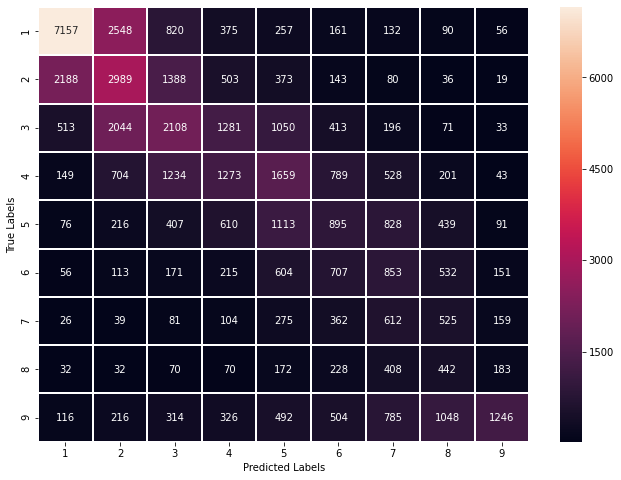

<Figure size 432x288 with 0 Axes>

In [217]:
fig, ax = plt.subplots(figsize=(11,8))
cf_matrix = pd.crosstab(test_y, pred_test_y_k)
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
plt.savefig('Confusion matrix for best model (RF regressor with optimized rounding).svg')

In [224]:
# Copied from Kaggle competition
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

roc_auc_dict = roc_auc_score_multiclass(test_y, pred_test_y_k)
roc_auc_dict

{1: 0.7680863936977015,
 2: 0.624594506742893,
 3: 0.584376150118537,
 4: 0.5571127993611269,
 5: 0.5658253040159351,
 6: 0.566843754249779,
 7: 0.6007860851966497,
 8: 0.6049280201218706,
 9: 0.6153629215629559}

**Find feature importance for best random forest regressor**

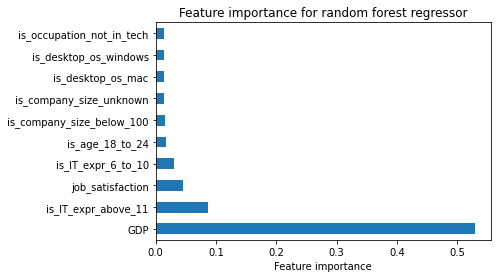

In [149]:
feat_importances = pd.Series(gbm_reg.feature_importances_, index=data_df.columns) #For RF with optimized rounding and optimal paramaters
# feat_importances.nlargest(4).plot(kind='barh')
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance')
plt.title('Feature importance for random forest regressor')
plt.savefig('Feature importance for random forest regressor.svg', bbox_inches='tight')

## Random forest classifier ##

In [115]:
labels = salary.astype(str) #For classification

#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

#Randomly sample 20000 data points to work up optimal depth search
np.random.seed(0)
sample = np.random.choice(len(x_train), 20000, replace = False)
x_train = x_train[sample]
y_train = y_train[sample]

In [ ]:
# depth_iter = 25
# RF_cl_test_error = []
# for depth in range(1, depth_iter):
#     randomForest_cl = RandomForestClassifier(max_depth = depth, random_state=0).fit(x_train, y_train)
#     randomForest_cl_pred = randomForest_cl.predict(x_test)
#     RF_cl_test_error.append(quadratic_weighted_kappa(randomForest_cl_pred, y_test))
#     print('Iteration {} done'.format(depth))

In [ ]:
# plt.plot(range(1, depth_iter), RF_cl_test_error)

In [ ]:
# opt_depth_RFcl = np.argmax(RF_cl_test_error)
# RF_cl_test_error[opt_depth_RFcl]

In [ ]:
# print('Optimal tree depth for RF classifier is {}'.format(opt_depth_RFcl+1))

In [120]:
maxdepth_grid = list(range(1, 31))
bagging_range = np.linspace(0.001, 1, num = 25)
random_grid = {'max_depth': maxdepth_grid, 'max_samples': bagging_range, 'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_cl_opt_params = rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [133]:
print(rf_cl_opt_params)

{'max_samples': 0.7086250000000001, 'max_features': 'auto', 'max_depth': 17}


**Find CV and test set scores for random forest classifier**

In [138]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]
    model = RandomForestClassifier(**rf_cl_opt_params, random_state=1)
    pred = model.fit(X_train, y_train).predict(X_test)
    qwk = quadratic_weighted_kappa(pred, y_test)
#         print('QWK is', qwk)
    cv_scores[idx] = qwk

print('Quadratic weighted Kappa for 5-fold CV for forest classifer is', np.mean(cv_scores))

Quadratic weighted Kappa for 5-fold CV for forest classifer is 0.5641682981879085


For default RF classifier, the quadratic weighted Kappa for 5-fold CV is 0.5239662276074672 

In [139]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

# randomForest_cl = RandomForestClassifier(max_depth = opt_depth_RFcl+1, random_state=0).fit(x_train, y_train)
randomForest_cl = RandomForestClassifier(**rf_cl_opt_params, random_state=1).fit(x_train, y_train)
randomForest_cl_pred = randomForest_cl.predict(x_test)
print('Quadratic weighted Kappa for random forest classifer for test dataset is', quadratic_weighted_kappa(randomForest_cl_pred, y_test))

Quadratic weighted Kappa for random forest classifer for test dataset is 0.5633360735599633


For default RF classifier, the quadratic weighted Kappa for test set is 0.5298166068007469

**Find feature importance for random forest classifier**

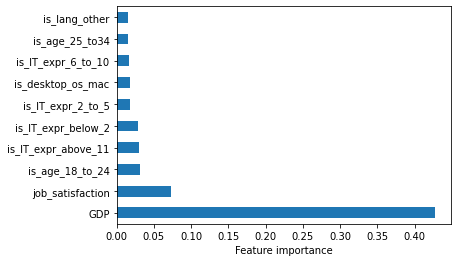

In [148]:
feat_importances = pd.Series(randomForest_cl.feature_importances_, index=data_df.columns)
# feat_importances.nlargest(4).plot(kind='barh')
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance')
plt.savefig('Feature importance for random forest regressor.svg', bbox_inches='tight')